**Problem Statement:** Predicting NYC Taxi Fare<br/>
**Goal:** Using XGBoost

Import Data and Libraries

In [1]:
# load some default Python modules
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import requests
from io import BytesIO

url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSdR1c5jpsE5Kp2DzQoIm7H2XywINfGNMnTL7nP92mu_GBHgu2T0mPxnu5O0YVfSpAbAu1NGNrm0auq/pub?output=csv'
r = requests.get(url)
csv_data = r.content
df_origin = pd.read_csv(BytesIO(csv_data))
train = df_origin[:90000]
test = df_origin[90000:]

In [4]:
# datatypes
train.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [5]:
# Basic Stats of the data set
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000
mean,11.341009,-72.500507,39.917580,-72.494134,39.918458,1.672733
std,9.687934,10.696395,6.216535,10.457200,6.084845,1.299121
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992016,40.734956,-73.991211,40.734200,1.000000
50%,8.500000,-73.981791,40.752742,-73.980018,40.753256,1.000000
75%,12.500000,-73.966995,40.767325,-73.963454,40.768182,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


following thing that i can notice

1. Fare amount is negative and it doesn't seem to be realistic
2. few longitude and lattitude entries are off
3. maximum passanger count is 208 which looks odd

In [6]:
print("old size: %d" % len(train))
train = train[train.fare_amount >=0]
print("New size: %d" % len(train))

old size: 90000
New size: 89992


In [7]:
# check missing data
train.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

There are 36 records where longitud and latitude are missing, we will drop them from the data

In [8]:
print("old size: %d" % len(train))
train = train.dropna(how='any', axis=0)
print("New size after dropping missing value: %d" % len(train))

old size: 89992
New size after dropping missing value: 89992


Text(0, 0.5, 'Frequency')

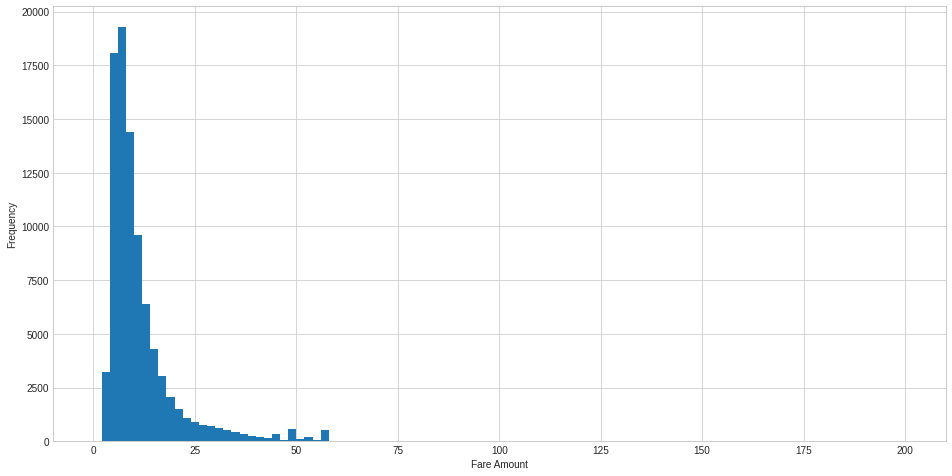

In [9]:
# Lets see the distribution of fare amount 
train.fare_amount.hist(bins=100, figsize = (16,8))
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")

1. Looks like the distribution is highly skewed and frequency above 100 is very less
2. we will plot below 100 and above 100 separately

Text(0, 0.5, 'Frequency')

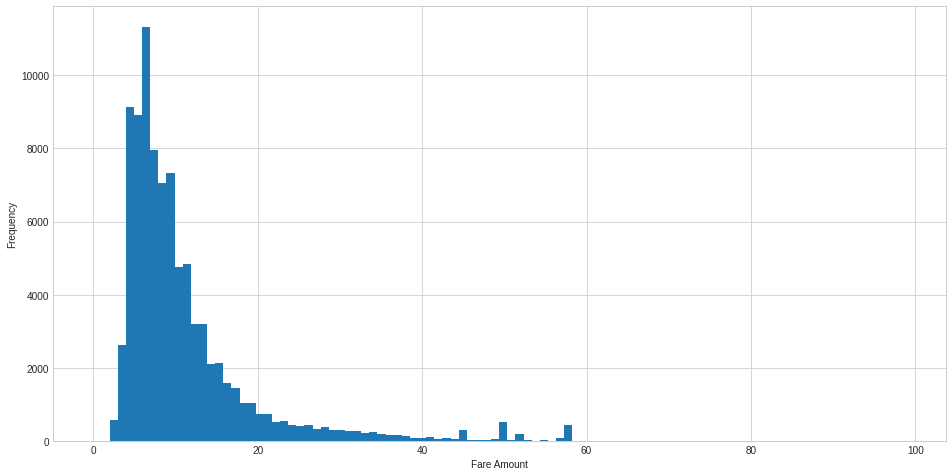

In [10]:
# Lets see the distribution of fare amount less than 100
train[train.fare_amount <100 ].fare_amount.hist(bins=100, figsize = (16,8))
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")

There are few points between 40 and 60 dollars which has slightly high frequency and that could be airport trips

In [11]:
train[train.fare_amount >100 ].shape

(34, 8)

Lets read the test data

In [13]:
#check for missing value
test.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

There are no missing values in test data set

In [14]:
# checking for basic stats
test.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
mean,11.478017,-72.442105,39.886504,-72.462313,39.924325,1.683668
std,9.972600,10.672673,6.308000,10.599212,7.269734,1.309652
min,-3.000000,-78.083332,-74.005410,-74.895028,-73.999742,0.000000
25%,6.000000,-73.992333,40.735240,-73.991260,40.734005,1.000000
50%,8.500000,-73.981767,40.753087,-73.979848,40.753052,1.000000
75%,12.600000,-73.966873,40.766666,-73.963287,40.767966,2.000000
max,150.000000,40.787575,69.400000,40.810297,404.616667,6.000000


We will store the minimum and maximum of the longitude and latitude from test data set and filter the train data set for those data points

In [15]:
min(test.pickup_longitude.min(),test.dropoff_longitude.min()), \
max(test.pickup_longitude.max(),test.dropoff_longitude.max())

(-78.083332, 40.810297)

In [16]:
min(test.pickup_latitude.min(),test.dropoff_latitude.min()), \
max(test.pickup_latitude.max(),test.dropoff_latitude.max())

(-74.00541, 404.616667)

In [17]:
# this function will also be used with the test set below
def select_within_test_boundary(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

In [18]:
BB = (-74.5, -72.8, 40.5, 41.8)
print('Old size: %d' % len(train))
train = train[select_within_test_boundary(train, BB)]
print('New size: %d' % len(train))

Old size: 89992
New size: 88084


Now we have sliced the train data records as per the coordinates of the test data

Manual Feature Engineering
1. Adding distance metrics
2. few time based variables

In [19]:
def prepare_time_features(df):
    df['pickup_datetime'] = df['pickup_datetime'].str.slice(0, 16)
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    df['hour_of_day'] = df.pickup_datetime.dt.hour
#     df['week'] = df.pickup_datetime.dt.week
    df['month'] = df.pickup_datetime.dt.month
    df["year"] = df.pickup_datetime.dt.year
#     df['day_of_year'] = df.pickup_datetime.dt.dayofyear
#     df['week_of_year'] = df.pickup_datetime.dt.weekofyear
    df["weekday"] = df.pickup_datetime.dt.weekday
#     df["quarter"] = df.pickup_datetime.dt.quarter
#     df["day_of_month"] = df.pickup_datetime.dt.day
    
    return df

In [20]:
train = prepare_time_features(train)
test = prepare_time_features(test)

In [21]:
# calculate-distance-between-two-latitude-longitude-points-haversine-formula 
# Returns distance in miles
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))   # 2*R*asin...

In [22]:
train['distance_miles'] = distance(train.pickup_latitude, train.pickup_longitude, \
                                      train.dropoff_latitude, train.dropoff_longitude)

In [23]:
test['distance_miles'] = distance(test.pickup_latitude, test.pickup_longitude, \
                                      test.dropoff_latitude, test.dropoff_longitude)

Calculating pickup and drop distance from all 3 airports of Air Ports

In [25]:
def transform(data):
    # Distances to nearby airports, 
    jfk = (-73.7781, 40.6413)
    ewr = (-74.1745, 40.6895)
    lgr = (-73.8740, 40.7769)

    data['pickup_distance_to_jfk'] = distance(jfk[1], jfk[0],
                                         data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_jfk'] = distance(jfk[1], jfk[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_ewr'] = distance(ewr[1], ewr[0], 
                                          data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_ewr'] = distance(ewr[1], ewr[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_lgr'] = distance(lgr[1], lgr[0],
                                          data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_lgr'] = distance(lgr[1], lgr[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    
    return data

train = transform(train)
test = transform(test)

Delete these 15 record where distance covered and fare amount are zero, which won't help our model

In [26]:
train[(train['distance_miles']==0)&(train['fare_amount']==0)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,month,year,weekday,distance_miles,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr


In [27]:
print("old size: %d" % len(train))
train = train.drop(index= train[(train['distance_miles']==0)&(train['fare_amount']==0)].index, axis=0)
print("New size: %d" % len(train))


old size: 88084
New size: 88084


There are 24 records where fare amount is zero but distance travelled is greater than 0, we will drop such case

In [28]:
train[train['fare_amount']==0].shape

(3, 19)

In [29]:
print("old size: %d" % len(train))
train = train.drop(index= train[train['fare_amount']==0].index, axis=0)
print("New size: %d" % len(train))

old size: 88084
New size: 88081


There are 53 record where fare amount is less than 2.5 dollars (most of them are 0.01 dollars except 3 cases of fare between 1 and 2 dollar ) which doesn't make sense as the base fare for any taxi in new york is 2.5 dollars, we will drop those cases

In [30]:
train[train['fare_amount'] < 2.5].shape

(1, 19)

In [31]:
print("old size: %d" % len(train))
train = train.drop(index= train[train['fare_amount'] < 2.5].index, axis=0)
print("New size: %d" % len(train))

old size: 88081
New size: 88080


1. There are stil 6 records left where passanger count is greater than 7
2. we will delete such cases because we don't have passanger count greater than 7 in test record

In [32]:
train[train.passenger_count >= 7]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,month,year,weekday,distance_miles,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr


In [33]:
print("old size: %d" % len(train))
train = train.drop(index= train[train.passenger_count >= 7].index, axis=0)
print("New size: %d" % len(train))

old size: 88080
New size: 88080


In [34]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,88080.0,11.329912,9.650315,2.500000,6.000000,8.500000,12.500000,200.000000
pickup_longitude,88080.0,-73.975013,0.038808,-74.438233,-73.992223,-73.982078,-73.968297,-72.856968
pickup_latitude,88080.0,40.751202,0.029979,40.500046,40.736626,40.753511,40.767730,41.692428
dropoff_longitude,88080.0,-73.973965,0.037878,-74.474595,-73.991388,-73.980443,-73.965142,-72.854940
dropoff_latitude,88080.0,40.751624,0.033120,40.500046,40.735795,40.753990,40.768513,41.714633
passenger_count,88080.0,1.673422,1.299395,0.000000,1.000000,1.000000,2.000000,6.000000
hour_of_day,88080.0,13.491281,6.508070,0.000000,9.000000,14.000000,19.000000,23.000000
month,88080.0,6.262954,3.455554,1.000000,3.000000,6.000000,9.000000,12.000000
year,88080.0,2011.741133,1.868424,2009.000000,2010.000000,2012.000000,2013.000000,2015.000000
weekday,88080.0,3.033912,1.951721,0.000000,1.000000,3.000000,5.000000,6.000000


Lets check the distribution of distance in miles covered for train and test data set

In [35]:
#train data set
pd.cut(train['distance_miles'],np.linspace(0, 70, num = 8)).value_counts()

(0.0, 10.0]     85301
(10.0, 20.0]     1799
(20.0, 30.0]       13
(60.0, 70.0]       11
(50.0, 60.0]        6
(40.0, 50.0]        1
(30.0, 40.0]        0
Name: distance_miles, dtype: int64

In [36]:
# test data set
pd.cut(test['distance_miles'],np.linspace(0, 70, num = 8)).value_counts()

(0.0, 10.0]     9444
(10.0, 20.0]     216
(20.0, 30.0]       4
(60.0, 70.0]       1
(50.0, 60.0]       1
(40.0, 50.0]       0
(30.0, 40.0]       0
Name: distance_miles, dtype: int64

In [37]:
# we will deal with it later 
fare_100 = train[train.fare_amount > 100]
fare_100.shape

(33, 19)

**There are 1669 records where fare amount is higher than 100 dollars**<br/>

1. I also see than 527 records are such where distance covered is even less than 1 miles
2. While researching through few websites (https://www.introducingnewyork.com/taxis, https://www.taxi-calculator.com/taxi-rate-new-york-city/259) i got to know that if taxi waits for passanger additional $30 dollars per hour will be charged depending on the location of the pickup.
3. Since we don't have such variable where we can get to know the waiting time, we can drop such cases where distance is very less in copare to fare amount charged for the ride

In [38]:
fare_100[fare_100.distance_miles <1].shape

(18, 19)

In [39]:
# #dropping cases where fare is above 100 dollars and distance is less than 1 miles
# print("old size: %d" % len(train))
# train = train.drop(index= train[(train.distance_miles <1) & (train.fare_amount > 100)].index, axis=0)
# print("New size: %d" % len(train))

In [40]:
train.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'hour_of_day', 'month', 'year', 'weekday',
       'distance_miles', 'pickup_distance_to_jfk', 'dropoff_distance_to_jfk',
       'pickup_distance_to_ewr', 'dropoff_distance_to_ewr',
       'pickup_distance_to_lgr', 'dropoff_distance_to_lgr'],
      dtype='object')

In [41]:
# create copy of the data set
df_train = train.drop(columns= ['key','pickup_datetime'], axis= 1).copy()
df_test = test.drop(columns= ['key','pickup_datetime'], axis= 1).copy()
print(df_train.shape)
print(df_test.shape)

(88080, 17)
(9999, 17)


Train Test Split

In [42]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(df_train.drop('fare_amount', axis=1),
                                                    df_train['fare_amount'], test_size=0.2, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(70464, 16)
(17616, 16)
(70464,)
(17616,)


## XG Boost Mode

In [43]:
import xgboost as xgb

In [44]:
params = {
   
    'max_depth': 7,
    'gamma' :0,
    'eta':.03, 
    'subsample': 1,
    'colsample_bytree': 0.9, 
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'silent': 0
}

In [45]:
def XGBmodel(X_train,X_test,y_train,y_test,params):
    matrix_train = xgb.DMatrix(X_train,label=y_train)
    matrix_test = xgb.DMatrix(X_test,label=y_test)
    model=xgb.train(params=params,
                    dtrain=matrix_train,num_boost_round=5000, 
                    early_stopping_rounds=10,evals=[(matrix_test,'test')])
    return model

model = XGBmodel(X_train,X_test,y_train,y_test,params)

[07:46:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:13.8699
Will train until test-rmse hasn't improved in 10 rounds.
[1]	test-rmse:13.4932
[2]	test-rmse:13.1513
[3]	test-rmse:12.7982
[4]	test-rmse:12.4552
[5]	test-rmse:12.1242
[6]	test-rmse:11.8059
[7]	test-rmse:11.4987
[8]	test-rmse:11.2004
[9]	test-rmse:10.9134
[10]	test-rmse:10.6533
[11]	test-rmse:10.3839
[12]	test-rmse:10.1239
[13]	test-rmse:9.86878
[14]	test-rmse:9.62576
[15]	test-rmse:9.39145
[16]	test-rmse:9.16612
[17]	test-rmse:8.94926
[18]	test-rmse:8.73785
[19]	test-rmse:8.53649
[20]	test-rmse:8.34098
[21]	test-rmse:8.15204
[22]	test-rmse:7.98297
[23]	test-rmse:7.80668
[24]	test-rmse:7.63635
[25]	test-rmse:7.4719
[26]	test-rmse:7.3165
[27]	test-rmse:7.16646
[28]	test-rmse:7.02236
[29]	test-rmse:6.88225
[30]	test-rmse:6.7497
[31]	test-rmse:6.6224
[32]	test-rmse:6.50028
[33]	test-rmse:6.37916
[34]	test-rmse:6.26743
[35]	test-rmse:6.16525
[3

In [47]:
#prediction = model.predict(xgb.DMatrix(df_test), ntree_limit = model.best_ntree_limit).tolist()
df_test = df_test.drop(columns=['fare_amount'])
prediction = model.predict(xgb.DMatrix(df_test), ntree_limit = model.best_ntree_limit).tolist()

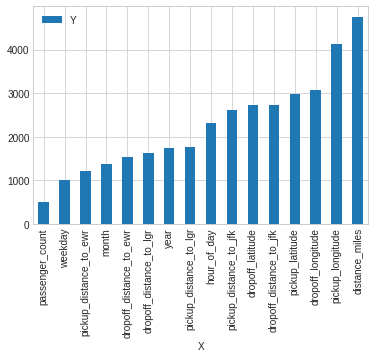

In [48]:
import matplotlib.pyplot as plt
fscores = pd.DataFrame({'X': list(model.get_fscore().keys()), 'Y': list(model.get_fscore().values())})
fscores.sort_values(by='Y').plot.bar(x='X')